In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
import matplotlib.dates as md
from scipy.optimize import leastsq,curve_fit
import math
import time
import datetime as dt
import pandas as pd

In [3]:
def open_data(exp_id):
    ## basic paths
    data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
    analysis_local_path='D:/Analysis/' # D:\ is local SSD in the main experiment computer
    analysis_master_path='Y:/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\
    experiment_file='results.hdf5'
    qdp_name='qdp.txt'

    exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
    exp_path=data_master_path+exp_date+'/'+exp_id+'/'
    analysis_path=analysis_master_path+exp_date+'/'+exp_id+'/'

    if not os.path.exists(analysis_path):
        os.makedirs(analysis_path)

    if os.path.isfile(analysis_path+qdp_name):
        print "Yay! found old qdp class. We can save time!"
        q = qdp.load_qdp(filename=analysis_path+qdp_name)
    else:
        print "Coudn't find processed qdp. Loading and saving"
        q = qdp.QDP(base_data_path=exp_path)
        q.load_data_file(experiment_file)
        q.save_qdp(filename=analysis_path+qdp_name)
    return q

def process_container(exp_id):
    q=open_data(exp_id)
    cuts=[[450],[450],[450]]
    for r in range(5):
        q.set_thresholds(cuts, roi=r)
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    retention = q.apply_thresholds()
    
    e=0
    timestamp=[]
    xdata=[]
    reten={}
    err={}
    container={}
    for i in q.experiments[e]['iterations']:
        iter_timestamp=q.experiments[e]['iterations'][i]['timestamp_iteration']
        timestamp.append(iter_timestamp)
        xdata.append(np.squeeze(retention['ivar'])[i][0])
        for roi in [0,1,2,3,4]:
            if i==0:
                reten[str(roi)]=[]
                err[str(roi)]=[]
            reten[str(roi)].append(np.squeeze(retention['retention'])[i][roi])
            err[str(roi)].append(np.squeeze(retention['error'])[e][roi])

    dates=[dt.datetime.fromtimestamp(ts) for ts in timestamp]
    container['exp_id']=exp_id
    container['timestamps']=timestamp
    container['datetime']=dates
    container['xdata']=xdata
    container['retentions']=reten
    container['errors']=err
    container['qdp_class']=q
    return container

def flatten(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list


def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-(x-x0)**2)/(sigma**2)))+offset
    return res

# Set experiment(s) to analyze


In [49]:
exp_ids=['2018_03_14_15_21_30_Microwave Ramsey with 780A, r2-r3',
        '2018_03_14_15_41_55_Microwave Ramsey with 780A, r2-r3',
         '2018_03_14_16_02_30_Microwave Ramsey with 780A, r2-r3',
         '2018_03_14_16_32_09_Microwave Ramsey with 780A, r2-r3',
         '2018_03_15_10_44_31_Microwave Ramsey with 780A, r2-r3',
         '2018_03_15_11_14_17_Microwave Ramsey with 780A, r2-r3, samples=25',
         '2018_03_15_11_40_05_Microwave Ramsey with 780A, r2-r3, samples=25',
         '2018_03_15_12_11_32_Microwave Ramsey with 780A, r2-r3, samples=25',
         '2018_03_16_11_10_00_Microwave Ramsey with 780A, r2-r3, samples=25'
         #'2018_03_16_11_45_36_Microwave Ramsey with 780A, larger timescale, r2-r3, samples=25'
        ]
assorted={}
assorted['qdp_class']=[]
assorted['exp_ids']=[]
assorted['timestamps']=[]
assorted['retentions']=[[],[],[],[],[]]
assorted['errors']=[[],[],[],[],[]]
for exp_id in exp_ids:
    container=process_container(exp_id)
    assorted['qdp_class'].append(container['qdp_class'])
    assorted['exp_ids'].append(container['exp_id'])
    assorted['timestamps'].append(container['timestamps'])
    for roi in [0,1,2,3,4]:
        assorted['retentions'][roi].append(container['retentions'][str(roi)])
        assorted['errors'][roi].append(container['errors'][str(roi)])


Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_03_14/2018_03_14_15_21_30_Microwave Ramsey with 780A, r2-r3/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_03_14/2018_03_14_15_41_55_Microwave Ramsey with 780A, r2-r3/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_03_14/2018_03_14_16_02_30_Microwave Ramsey with 780A, r2-r3/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_03_14/2018_03_14_16_32_09_Microwave Ramsey with 780A, r2-r3/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_03_15/2018_03_15_10_44_31_Microwave Ramsey with 780A, r2-r3/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_03_15/2018_03_15_11_14_17_Microwave Ramsey with 780A, r2-r3, samples=25/qdp.txt
Yay! found old qdp class. We can save time!
qd

# Experiment-wise analysis

In [50]:
assorted['exp_ids']

['2018_03_14_15_21_30_Microwave Ramsey with 780A, r2-r3',
 '2018_03_14_15_41_55_Microwave Ramsey with 780A, r2-r3',
 '2018_03_14_16_02_30_Microwave Ramsey with 780A, r2-r3',
 '2018_03_14_16_32_09_Microwave Ramsey with 780A, r2-r3',
 '2018_03_15_10_44_31_Microwave Ramsey with 780A, r2-r3',
 '2018_03_15_11_14_17_Microwave Ramsey with 780A, r2-r3, samples=25',
 '2018_03_15_11_40_05_Microwave Ramsey with 780A, r2-r3, samples=25',
 '2018_03_15_12_11_32_Microwave Ramsey with 780A, r2-r3, samples=25',
 '2018_03_16_11_10_00_Microwave Ramsey with 780A, r2-r3, samples=25']

<IPython.core.display.Javascript object>


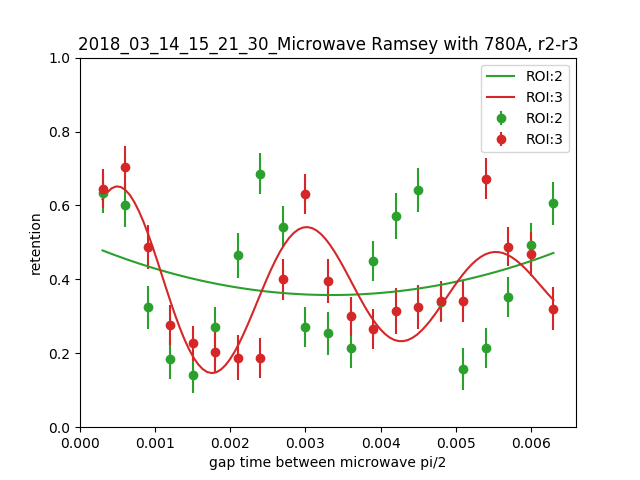

ROI:2, tau : -53.1179012409, amplitude 164.478978389 , freq:-2.00324184834, phase:-1.53020980324, offset:164.846770269
freq uncertainty: 24293.7416092
ROI:3, tau : 0.0051189603254, amplitude 0.313458017683 , freq:-397.247115548, phase:2.89172753433, offset:0.368126481173
freq uncertainty: 16.7163239684


<IPython.core.display.Javascript object>


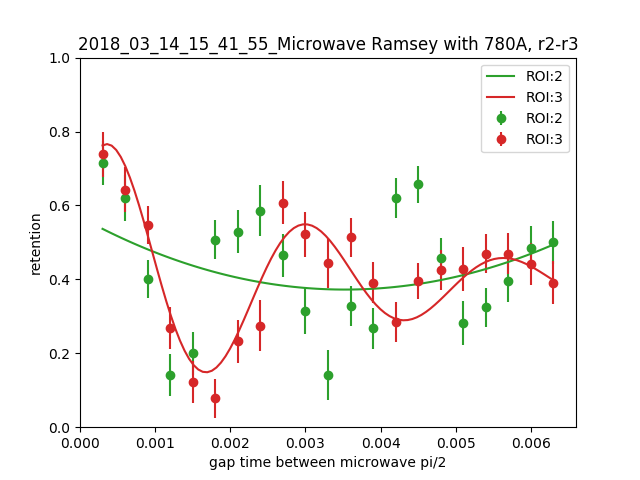

ROI:2, tau : -61.5324284726, amplitude -167.757121111 , freq:2.18485002397, phase:1.52360398461, offset:168.138990126
freq uncertainty: 28975.8980036
ROI:3, tau : 0.00304587049625, amplitude 0.425309288223 , freq:-379.361380027, phase:2.5621234479, offset:0.391492985023
freq uncertainty: 14.6796450694


<IPython.core.display.Javascript object>


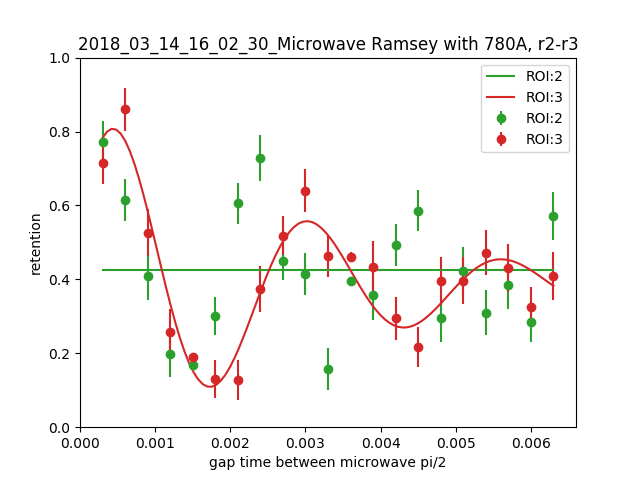

ROI:2, tau : 1.16804570465e-05, amplitude 0.277218175626 , freq:3.30256453996, phase:-0.0255517969117, offset:0.424662259292
freq uncertainty: inf
ROI:3, tau : 0.00291112986359, amplitude 0.499454026483 , freq:-387.467866094, phase:2.77651146609, offset:0.382133396437
freq uncertainty: 12.8364404488


<IPython.core.display.Javascript object>


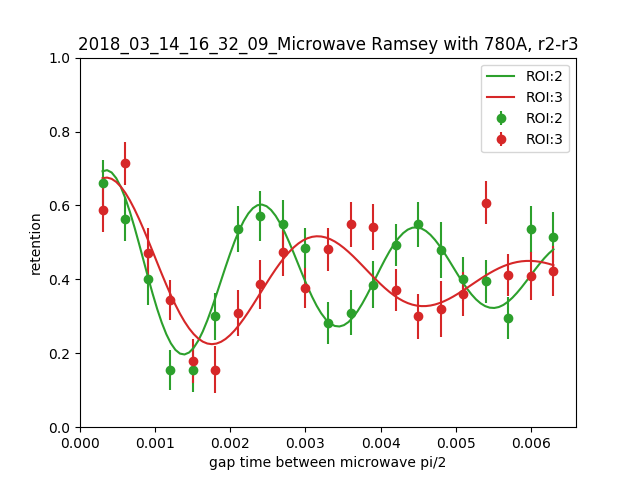

ROI:2, tau : 0.00498459914208, amplitude 0.295785474327 , freq:-485.710609005, phase:2.70346195348, offset:0.42045684816
freq uncertainty: 10.8953748195
ROI:3, tau : 0.00323734550561, amplitude 0.307692784166 , freq:-355.627369971, phase:2.48946704475, offset:0.40186063111
freq uncertainty: 25.1574927233


<IPython.core.display.Javascript object>


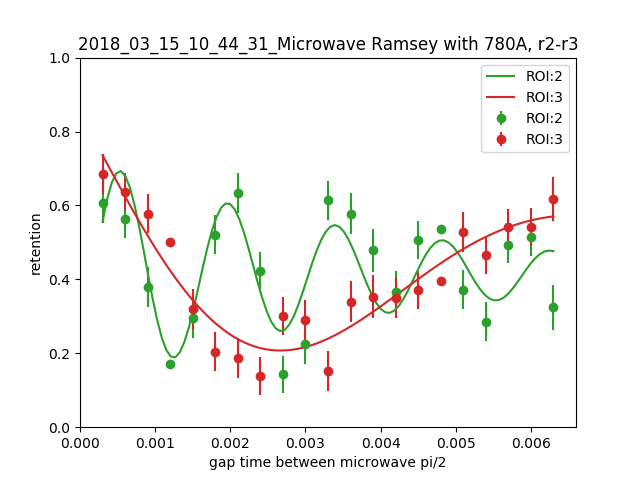

ROI:2, tau : 0.00379104996196, amplitude -0.318569295845 , freq:699.830021662, phase:-3.96754636493, offset:0.416799340399
freq uncertainty: 21.0474959222
ROI:3, tau : 0.004294148446, amplitude 0.508214355289 , freq:-126.619898125, phase:0.834804753616, offset:0.469580547011
freq uncertainty: 32.083952416


<IPython.core.display.Javascript object>


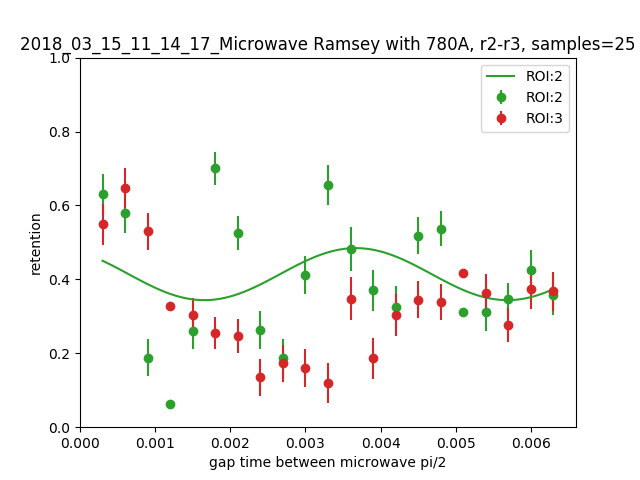

ROI:2, tau : -8356.13483881, amplitude 0.0704058691133 , freq:-247.970132173, phase:7.2898947293, offset:0.414161298027
freq uncertainty: 69.5260535392


<IPython.core.display.Javascript object>


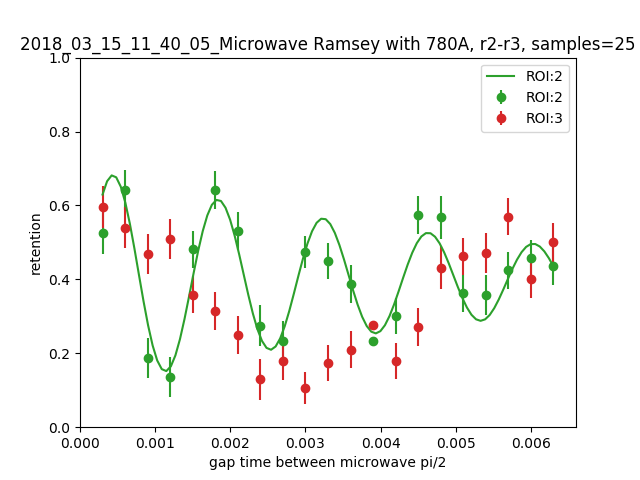

ROI:2, tau : 0.00524334288663, amplitude 0.307757213877 , freq:-715.157529252, phase:3.57432742216, offset:0.399034618959
freq uncertainty: 10.7418980332


<IPython.core.display.Javascript object>


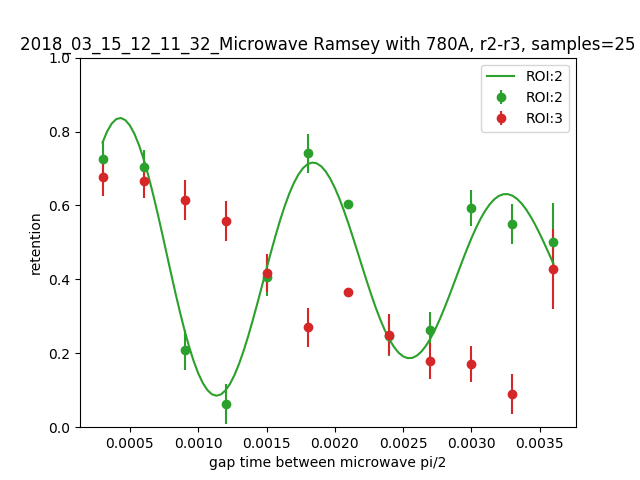

ROI:2, tau : 0.00403127166901, amplitude -0.45517165538 , freq:708.456669885, phase:-3.53355655958, offset:0.428179848096
freq uncertainty: 14.3641748923


<IPython.core.display.Javascript object>


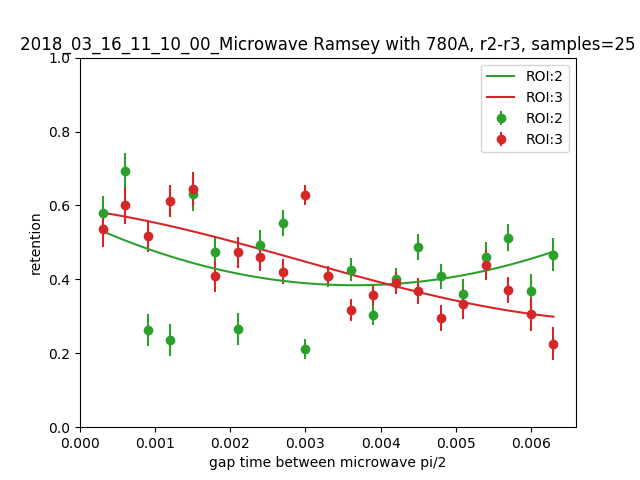

ROI:2, tau : -7.45319466814, amplitude 275.125848966 , freq:1.54715131387, phase:-1.59251146537, offset:275.618629392
freq uncertainty: 10168.6194655
ROI:3, tau : -1396.05367596, amplitude -0.162531125011 , freq:56.1224655397, phase:-1.05318492773, offset:0.44854206325
freq uncertainty: 110.8073158


In [59]:
assorted_roi3freqs=[]
assorted_roi2freqs=[]
assorted_roi3perr=[]
assorted_roi2perr=[]
for i in range(0,len(assorted['exp_ids'])):
    exp_id=assorted['exp_ids'][i]
    q=assorted['qdp_class'][i]
    q.experiments[0]['variable_list']
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    q.get_thresholds()
    retention = q.apply_thresholds()
    
    colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    fig, ax = plt.subplots()
    fit_guesses=[0.01,0.4,5,0,0.5]
    roi_dependency=[0,0,0,0,0]
    fitted_parameters=[]
    for roi in [2,3]:
        error=0
        data = []
        reten = []
        err = []
        for e in range(len(np.squeeze(retention['ivar']))):
            data.append(np.squeeze(retention['ivar'])[e][roi])
            reten.append(np.squeeze(retention['retention'])[e][roi])
            err.append(np.squeeze(retention['error'])[e][roi])
        ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',color=colors[roi])
        guesses=np.add(fit_guesses,np.ones(len(fit_guesses))*(roi-2)*roi_dependency)
        try:
            fit,pcov = curve_fit(decaying_sin,data,reten,guesses)
        except RuntimeError:
            error=1
        if error is not 1:
            print "ROI:{}, tau : {}, amplitude {} , freq:{}, phase:{}, offset:{}".format(roi,fit[0],fit[1],fit[2],fit[3],fit[4])
            print "freq uncertainty: {}".format(np.sqrt(pcov[2][2]))
            fitted_parameters.append(fit[0])
            xarray=np.linspace(np.min(data),np.max(data),100)
            yfit=decaying_sin(xarray, fit[0],fit[1],fit[2],fit[3],fit[4])
            plt.plot(xarray,yfit,label="ROI:{}".format(roi),color=colors[roi])

            if roi==3:
                assorted_roi3freqs.append(fit[2])
                assorted_roi3perr.append(np.sqrt(pcov[2][2]))
            elif roi==2:
                assorted_roi2freqs.append(fit[2])
                assorted_roi2perr.append(np.sqrt(pcov[2][2]))

    plt.show()
    ax.set_title(exp_id)
    ax.set_ylim(0, 1)
    ax.set_xlabel(xlab)
    ax.set_ylabel('retention')
    ax.legend()
    

In [64]:
exp_timestamps=[]
for i in range(0,len(exp_ids)):
    exp_timestamps.append(assorted['timestamps'][i][0])
assorted_roi2freqs=[514.90161706507558, 495.31534682608401, 493.46628345222257, 485.71136998981342, 699.83042436724679, 702.74031691048935, 715.15775952105139, 705.10179810539705, 987.86069094608592]
assorted_roi2perr=[6.5861617076553189, 11.355363613875754, 15.351284475799666, 10.89516146393262, 21.046767882740376, 11.450237976361826, 10.741572558962449, 20.002684488570033, 12.274267158798535]
assorted_roi3freqs=[397.24868610493758, 379.36221442148229, 387.4685592504581, 355.6288182874153, 126.61890501785139, 192.24818394685988, 176.100297045031, 208.154118975,56.1224655397]
assorted_roi3perr=[16.716212530836263, 14.679333404173525, 12.836391477804618, 25.156946026283553, 32.08142335078827, 20.834039410382719, 14.205072626153989, 52.2333137635,110.8073158]
dates=[dt.datetime.fromtimestamp(ts) for ts in exp_timestamps]
df=pd.DataFrame({'r2 freq':assorted_roi2freqs,
                 'r2 freq sigma':assorted_roi2perr,
                 'r3 freq':assorted_roi3freqs,
                 'r3 freq sigma':assorted_roi3perr,
                },index=dates)
print df


                            r2 freq  r2 freq sigma     r3 freq  r3 freq sigma
2018-03-14 15:21:36.749  514.901617       6.586162  397.248686      16.716213
2018-03-14 15:42:10.437  495.315347      11.355364  379.362214      14.679333
2018-03-14 16:02:44.921  493.466283      15.351284  387.468559      12.836391
2018-03-14 16:32:16.095  485.711370      10.895161  355.628818      25.156946
2018-03-15 10:44:40.998  699.830424      21.046768  126.618905      32.081423
2018-03-15 11:14:27.934  702.740317      11.450238  192.248184      20.834039
2018-03-15 11:40:14.453  715.157760      10.741573  176.100297      14.205073
2018-03-15 12:11:42.196  705.101798      20.002684  208.154119      52.233314
2018-03-16 11:10:06.405  987.860691      12.274267   56.122466     110.807316


<IPython.core.display.Javascript object>


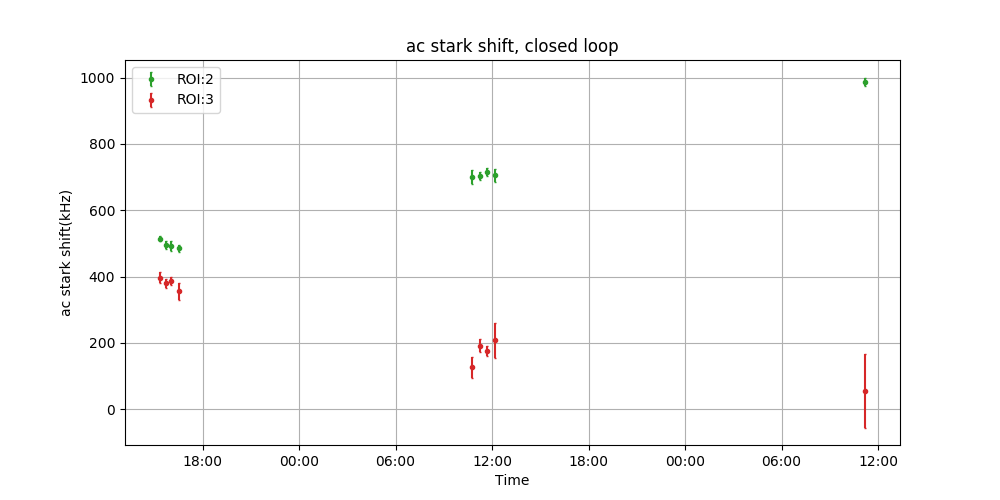

In [113]:
dates=[dt.datetime.fromtimestamp(ts) for ts in exp_timestamps]
xfmt=md.DateFormatter('%H:%M')
figW=10
figH=5
fig, ax = plt.subplots()
fig.set_size_inches(figW,figH)
ax.xaxis.set_major_formatter(xfmt)
data_to_plot=assorted_roi2freqs
ax.errorbar(dates, assorted_roi2freqs, yerr=assorted_roi2perr,fmt='o',markersize=3,color=colors[2],capsize=1,label='ROI:2')
ax.errorbar(dates, assorted_roi3freqs, yerr=assorted_roi3perr,fmt='o',markersize=3,color=colors[3],capsize=1,label='ROI:3')
#ax.set_xlim(dates[0],dates[-1])
ax.legend()
ax.set_title('ac stark shift, closed loop')
ax.grid()
ax.set_xlabel('Time')
ax.set_ylabel('ac stark shift(kHz)')
plt.savefig('ClosedloopAAS_AC_Starkshift_20180314_through_20180316.jpg')
plt.savefig('ClosedloopAAS_AC_Starkshift_20180314_through_20180316.png')
plt.savefig('ClosedloopAAS_AC_Starkshift_20180314_through_20180316.pdf')

<IPython.core.display.Javascript object>


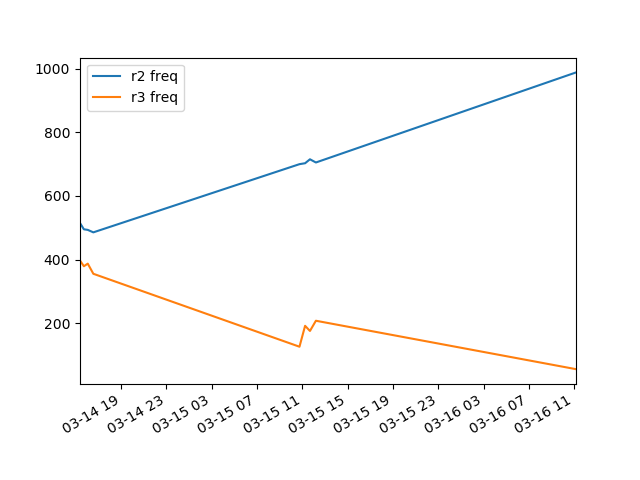

In [65]:
ax=df.plot(y=['r2 freq','r3 freq'],marker='.',markersize=0.02)
#ax.grid()
#ax.legend()

# Analyzing experiments without atoms

In [114]:
keylist=['Red_camera_dataX',
 'Red_camera_dataY',
  'FORT_camera_dataX',
'FORT_camera_dataY',
 'timestamp_measurements',
 'timestamp_iteration']

exp_ids=['2018_03_14_15_21_30_Microwave Ramsey with 780A, r2-r3',
        '2018_03_14_15_41_55_Microwave Ramsey with 780A, r2-r3',
         '2018_03_14_16_02_30_Microwave Ramsey with 780A, r2-r3',
         '2018_03_14_16_32_09_Microwave Ramsey with 780A, r2-r3',
         '2018_03_15_10_44_31_Microwave Ramsey with 780A, r2-r3',
         '2018_03_15_11_14_17_Microwave Ramsey with 780A, r2-r3, samples=25',
         '2018_03_15_11_40_05_Microwave Ramsey with 780A, r2-r3, samples=25',
         '2018_03_15_12_11_32_Microwave Ramsey with 780A, r2-r3, samples=25',
         '2018_03_16_11_10_00_Microwave Ramsey with 780A, r2-r3, samples=25'
         #'2018_03_16_11_45_36_Microwave Ramsey with 780A, larger timescale, r2-r3, samples=25'
         ,'2018_03_20_00_18_25_Open loop camera data purpose',
         '2018_03_20_00_43_36_Open loop camera data purpose'
        ]

data={}
for j in range(0,len(exp_ids)):
    exp_id=exp_ids[j]
    q=open_data(exp_id)
    e=0
    for i in q.experiments[e]['iterations']:
        for key in keylist:
            if i==0 and j==0:
                data[key]=[]
            try:
                data[key].append(q.experiments[e]['iterations'][i][key])
            except:
                print "error occured : exp {}, iter {}, key {}".format(exp_id, i, key)
    

Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_03_14/2018_03_14_15_21_30_Microwave Ramsey with 780A, r2-r3/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_03_14/2018_03_14_15_41_55_Microwave Ramsey with 780A, r2-r3/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_03_14/2018_03_14_16_02_30_Microwave Ramsey with 780A, r2-r3/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_03_14/2018_03_14_16_32_09_Microwave Ramsey with 780A, r2-r3/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_03_15/2018_03_15_10_44_31_Microwave Ramsey with 780A, r2-r3/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_03_15/2018_03_15_11_14_17_Microwave Ramsey with 780A, r2-r3, samples=25/qdp.txt
Yay! found old qdp class. We can save time!
qd

<IPython.core.display.Javascript object>


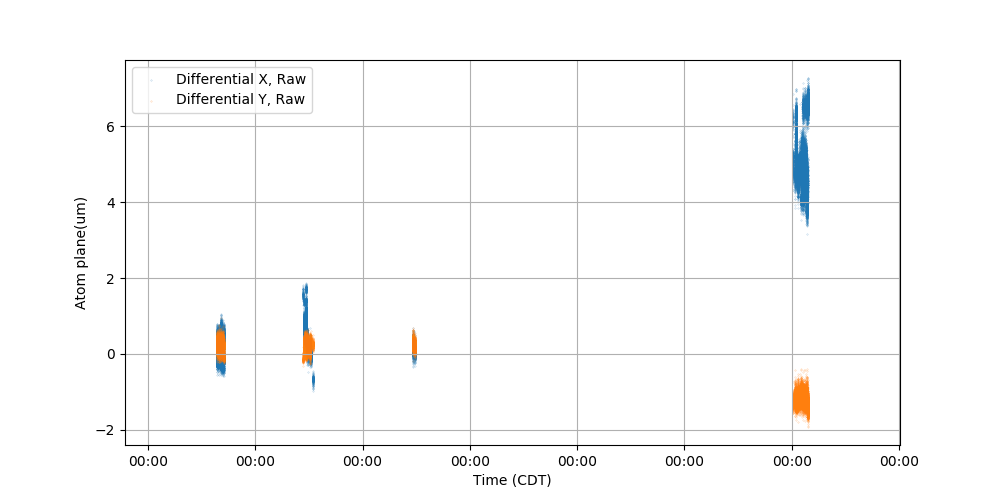

In [118]:
# Raw plotting
savefig=True
data_cutoff=0
xfmt=md.DateFormatter('%H:%M')
figW=10
figH=5
fig, ax = plt.subplots()
fig.set_size_inches(figW,figH)
flattendedtimestamps=np.array(flatten(data[keylist[4]]))
dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps][data_cutoff:]

flatteneddata0=np.array(flatten(data[keylist[0]]))[data_cutoff:]
flatteneddata2=np.array(flatten(data[keylist[2]]))[data_cutoff:]
flatteneddata1=np.array(flatten(data[keylist[1]]))[data_cutoff:]
flatteneddata3=np.array(flatten(data[keylist[3]]))[data_cutoff:]

ax.xaxis.set_major_formatter(xfmt)
data_to_plot=flatteneddata0-flatteneddata2-(flatteneddata0[0]-flatteneddata2[0])
ax.scatter(dates,data_to_plot,s=0.05,alpha=0.5,label='Differential X, Raw')
#ax.set_xlim(dates[0],dates[-1])

data_to_plot2=flatteneddata1-flatteneddata3-(flatteneddata1[0]-flatteneddata3[0])
ax.scatter(dates,data_to_plot2,s=0.05,alpha=0.5,label='Differential Y, Raw')
ax.grid()
ax.set_xlabel('Time (CDT)')
ax.set_ylabel('Atom plane(um)')
ax.legend()
#ax.set_ylim(-2,2)
plt.tight_layout()
if savefig:
    plt.savefig('ClosedloopAAS_AC_Starkshift_20180314_through_20180316_and_openloop.png')

In [119]:
# Using Pandas
data_cutoff=0
flattendedtimestamps=np.array(flatten(data[keylist[4]]))
dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps][data_cutoff:]

flatteneddata0=np.array(flatten(data[keylist[0]]))[data_cutoff:]
flatteneddata2=np.array(flatten(data[keylist[2]]))[data_cutoff:]
flatteneddata1=np.array(flatten(data[keylist[1]]))[data_cutoff:]
flatteneddata3=np.array(flatten(data[keylist[3]]))[data_cutoff:]

samplerate='1S'
offsetX=(flatteneddata0-flatteneddata2)[0]
offsetY=(flatteneddata1-flatteneddata3)[0]
df=pd.DataFrame({'Differential X': flatteneddata0-flatteneddata2-offsetX,
                 'Differential Y': flatteneddata1-flatteneddata3-offsetY,
                 'Red X': flatteneddata0-flatteneddata0[0],
                 'Red Y': flatteneddata1-flatteneddata1[0],
                 'FORT X': flatteneddata2-flatteneddata2[0],
                 'FORT Y': flatteneddata3-flatteneddata3[0]
                },index=dates)

<IPython.core.display.Javascript object>


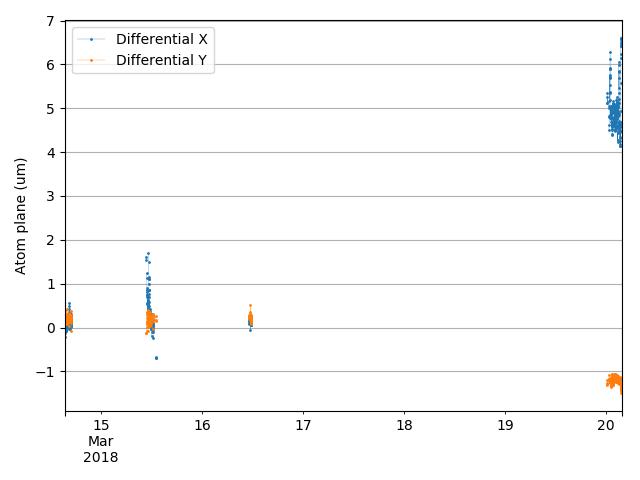

<IPython.core.display.Javascript object>


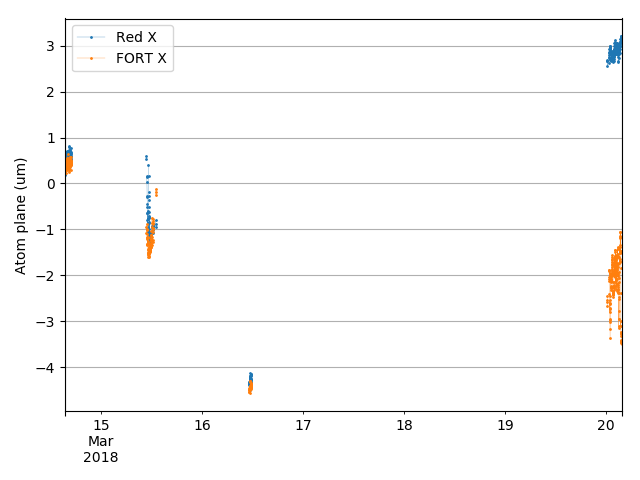

<IPython.core.display.Javascript object>


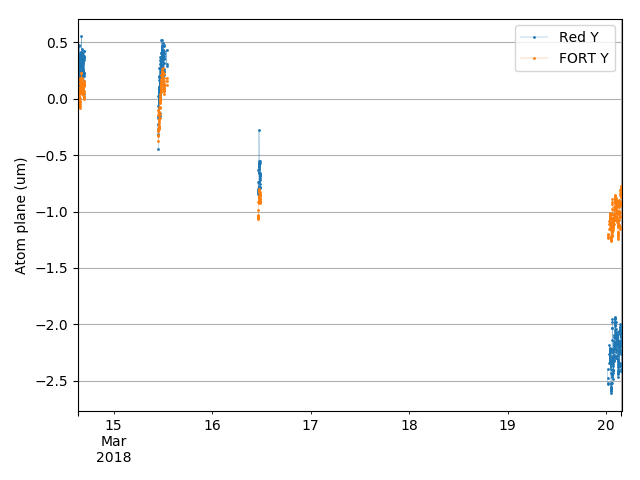

In [124]:
samplerate='60S'
data_to_plot2=df.resample(samplerate).mean()
ax=data_to_plot2.plot(y=['Differential X','Differential Y'],lw=0.2,marker='.',markersize=2)
ax.set_ylabel('Atom plane (um)')
ax.grid()
ax.legend()
plt.tight_layout()
if savefig:
    plt.savefig('ClosedloopAAS_AC_Starkshift_20180314_through_20180316_and_openloop_Diff.png',dpi=600)
#ax.set_ylim(-1,1)

#samplerate='1S'
data_to_plot2=df.resample(samplerate).mean()
ax=data_to_plot2.plot(y=['Red X','FORT X'],lw=0.2,marker='.',markersize=2)
ax.set_ylabel('Atom plane (um)')
ax.grid()
ax.legend()
plt.tight_layout()
if savefig:
    plt.savefig('ClosedloopAAS_AC_Starkshift_20180314_through_20180316_and_openloop_AbsX.png',dpi=600)
#ax.set_ylim(-5,2)

#samplerate='1S'
data_to_plot2=df.resample(samplerate).mean()
ax=data_to_plot2.plot(y=['Red Y','FORT Y'],lw=0.2,marker='.',markersize=2)
ax.set_ylabel('Atom plane (um)')
ax.grid()
ax.legend()
plt.tight_layout()
if savefig:
    plt.savefig('ClosedloopAAS_AC_Starkshift_20180314_through_20180316_and_openloop_AbsY.png',dpi=600)

#ax.set_ylim(-1.5,1)

<IPython.core.display.Javascript object>


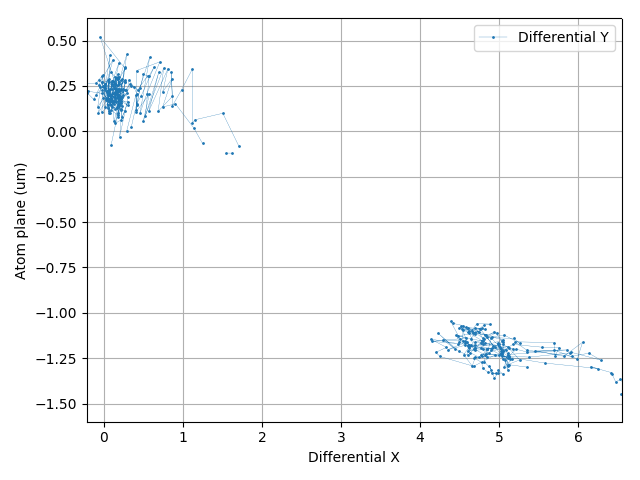

In [123]:
samplerate='60S'
data_to_plot2=df.resample(samplerate).mean()
ax=data_to_plot2.plot(x=['Differential X'],y=['Differential Y'],lw=0.2,marker='.',markersize=2)
ax.set_ylabel('Atom plane (um)')
ax.grid()
ax.legend()
plt.tight_layout()

# Allan deviation

In [7]:
# Allan 
tau_list=range(1,1000)
samplerates=[]
for i in tau_list:
    samplerates.append('{}S'.format(i))
        
samplerate='1S'

var_list={}

original_resampled=df.resample(samplerate).mean()

for i in range(0,len(tau_list)):
    avg_samplerate=samplerates[i]
    tau=tau_list[i]
    #print i
    try:
        downsampled=df.resample(avg_samplerate).mean() # Takes block-average for given time chuck size
        for key in downsampled:
            values=downsampled[key].values
            Xtau=values[1:]
            Xo=values[0:-1]
            var=np.nanmean(np.abs(Xtau-Xo))
            if i==0:
                var_list[key]=[]
            var_list[key].append(var)
    except:
        pass
    #Y=downsampled['Differential X'].values
    #Xstd.append(newdata['Differential X'].std())
    #Ystd.append(newdata['Differential Y'].std())

<IPython.core.display.Javascript object>


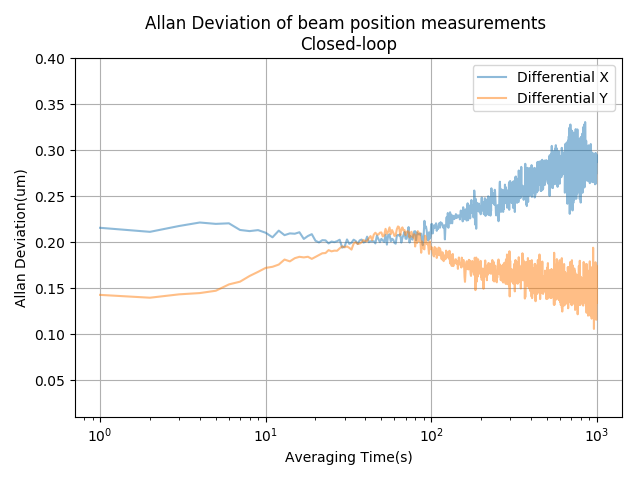

In [8]:
fig, ax = plt.subplots()
#xdata=tau_lists
#for key in var_list:
for key in ['Differential X','Differential Y']:
    ax.semilogx(tau_list, np.sqrt(0.5*np.array(var_list[key])),label=key,alpha=0.5)
#ax.semilogx(tau_list, np.sqrt(Yvar_list),label='Diff X',alpha=0.5)
# ax.plot(xdata,np.sqrt(Xvariance_list),label='Diff X',alpha=0.5)
# ax.plot(xdata,np.sqrt(Yvariance_list),label='Diff Y',alpha=0.5)
ax.legend()
#ax.set_xlim(1,)
ax.set_title('Allan Deviation of beam position measurements \nClosed-loop')
ax.set_xlabel('Averaging Time(s)')
ax.set_ylabel('Allan Deviation(um)')
#ax.axvline(x=60,color='k',alpha=0.3)
ax.set_ylim(0.01,0.4)
ax.grid()
plt.tight_layout()
if savefig:
    plt.savefig('AllanDeviation_Closedloop_Kp=0.1.png')
    plt.savefig('AllanDeviation_Closedloop_Kp=0.1.pdf')

<IPython.core.display.Javascript object>


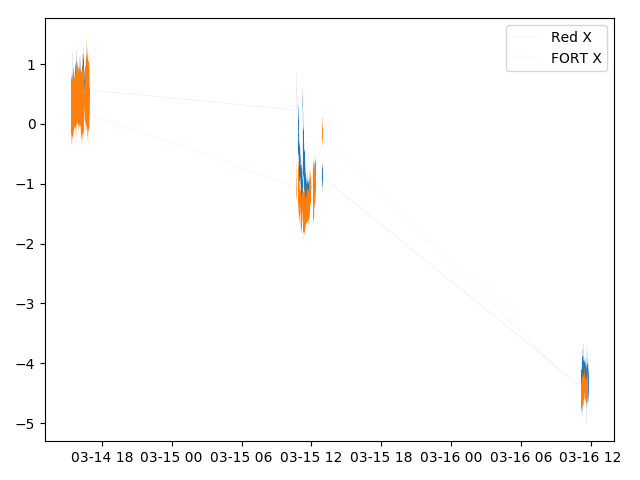

<IPython.core.display.Javascript object>


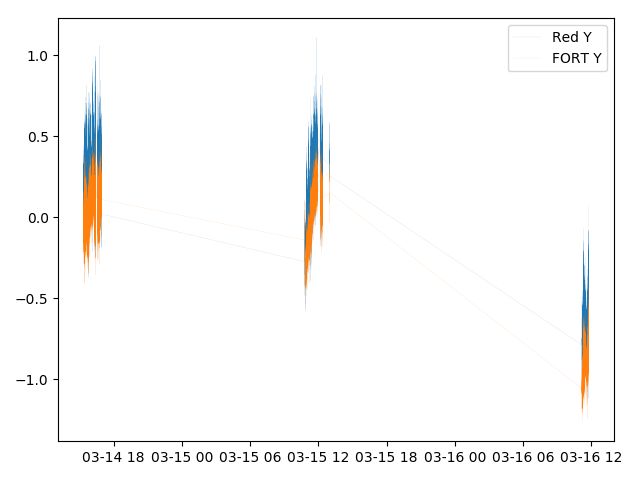

In [27]:
fig, ax = plt.subplots()
for key in ['Red X','FORT X']:
    plt.plot(df[key]-df[key][0],lw=0.05)
ax.legend()
plt.tight_layout()
            
fig, ax = plt.subplots()
for key in ['Red Y','FORT Y']:
    plt.plot(df[key]-df[key][0],lw=0.05)
ax.legend()
plt.tight_layout()



In [17]:
df['Red X']

2018-03-14 15:21:36.766    116.732819
2018-03-14 15:21:37.341    116.708052
2018-03-14 15:22:07.609    117.022528
2018-03-14 15:22:07.908    117.066375
2018-03-14 15:22:08.202    117.077579
2018-03-14 15:22:08.505    117.131275
2018-03-14 15:22:08.823    117.131373
2018-03-14 15:22:09.119    117.122426
2018-03-14 15:22:09.429    117.114364
2018-03-14 15:22:09.725    116.988930
2018-03-14 15:22:10.021    117.023314
2018-03-14 15:22:10.323    117.047232
2018-03-14 15:22:10.635    116.978607
2018-03-14 15:22:10.948    116.945907
2018-03-14 15:22:11.256    116.929148
2018-03-14 15:22:11.561    116.954730
2018-03-14 15:22:11.855    116.875580
2018-03-14 15:22:12.156    116.874401
2018-03-14 15:22:12.475    116.951808
2018-03-14 15:22:12.775    116.920259
2018-03-14 15:22:13.073    116.941584
2018-03-14 15:22:13.388    116.942957
2018-03-14 15:22:13.687    116.896536
2018-03-14 15:22:13.990    116.854521
2018-03-14 15:22:14.318    116.746190
2018-03-14 15:22:14.640    116.774448
2018-03-14 1